In [42]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(

    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

simplefilter('ignore')

pd.set_option('display.max_columns',None)

In [43]:
data_dir = Path('data')

store_sales = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['date','store_nbr','family','sales','onpromotion'],
    parse_dates=['date'],
    infer_datetime_format=True,
    dtype={
        'store_nbr':'category',
        'family':'category',
        'sales':'float32'
    },
)

store_sales['date'] = store_sales.date.dt.to_period('D')

store_sales = store_sales.set_index(['store_nbr','family','date']).sort_index()


family_sales = (
    store_sales
    .groupby(['family','date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [44]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

    def fit(self,X_1,X_2,y):
        self.model_1.fit(X_1,y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            columns= y.columns,
            index=X_1.index
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()
        #fit on resids
        self.model_2.fit(X_2, y_resid)
        self.y_columns = y.columns

    def predict(self,X_1,X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            columns=self.y_columns,
            index=X_1.index
        )
        y_pred = y_pred.stack().squeeze()
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()


#### Fit Trend

In [45]:
# Featurs for X_1
y = family_sales.loc[:,'sales']
dp = DeterministicProcess(
    index=y.index,
    order=1
)
X_1 = dp.in_sample()

# Features for X_2
X_2 = family_sales.drop('sales',axis=1).stack()
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
X_2['day'] = X_2.index.day

X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [46]:
y_train, y_val = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_val = X_1[:'2017-07-01'], X_1['2017-07-02':] 
X2_train, X2_val = X_2.loc[:'2017-07-01'], X_2.loc['2017-07-02':]

In [47]:
model = BoostedHybrid(
    LinearRegression(),
    XGBRegressor()
)

model.fit(X1_train,X2_train,y_train)

y_fit = model.predict(X1_train,X2_train)
y_pred = model.predict(X1_val,X2_val)

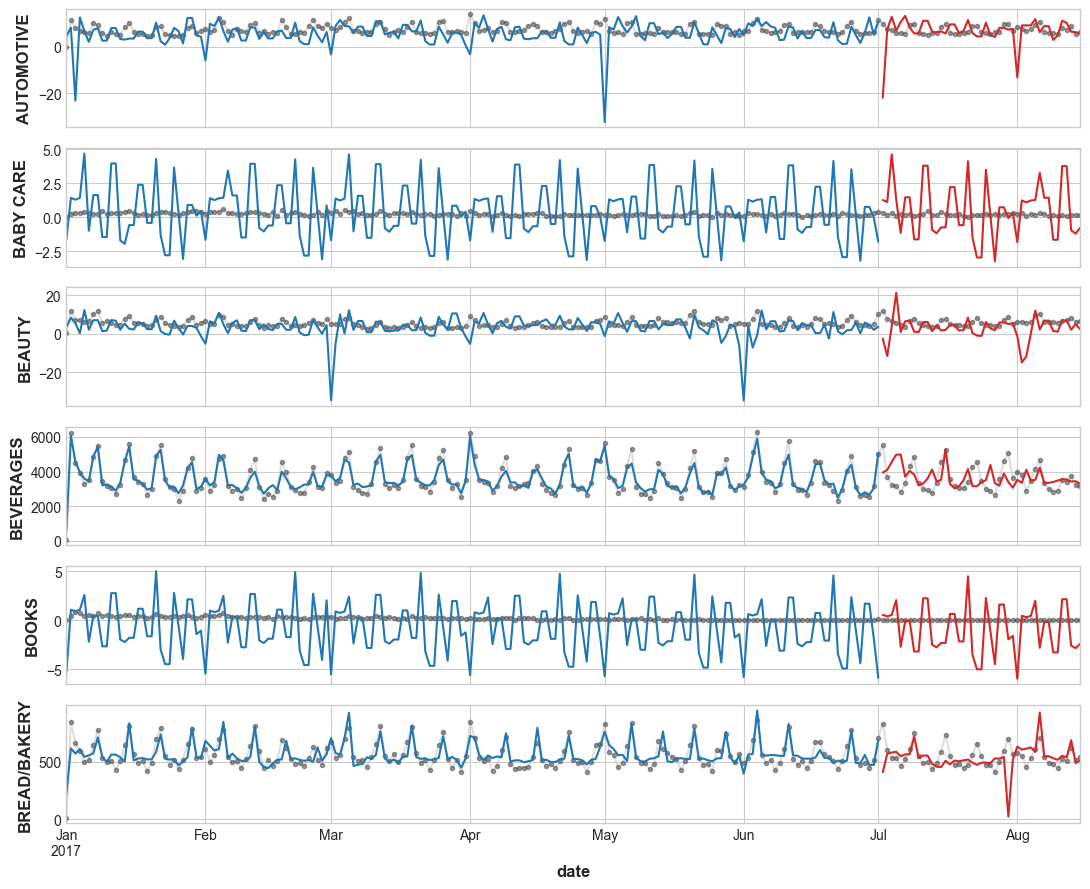

In [48]:
families = y.columns[0:6]

axs = y.loc(axis=1)[families].plot(
    **plot_params, subplots=True, sharex=True, figsize=(11,9),alpha=0.5
)
_ = y_fit.loc(axis=1)[families].plot(ax=axs, color='C0',subplots=True, sharex=True)
_ = y_pred.loc(axis=1)[families].plot(ax=axs, color='C3', subplots=True, sharex=True)

for ax, family in zip(axs,families):
    ax.legend([])
    ax.set_ylabel(family)

plt.show()

In [49]:
y.loc(axis=1)[families]

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY
date,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304
2017-01-03,8.296296,0.296296,7.185185,4507.814941,0.814815,665.124146
2017-01-04,6.833333,0.333333,6.888889,3911.833252,0.759259,594.160645
2017-01-05,6.333333,0.351852,5.925926,3258.796387,0.407407,495.511597
...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055664,0.000000,522.305298
2017-08-12,7.462963,0.055556,6.833333,3376.259277,0.000000,507.473114
2017-08-13,8.907408,0.166667,8.018518,3747.296387,0.018519,615.976990
